In [286]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

plt.style.use('ggplot')

## Read data

In [287]:
# print pandas version
print(pd.__version__)

1.5.0


In [288]:
df = pd.read_csv('./data/data.csv')

In [289]:
# display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

## Label analysis

In [290]:
# display all unique values in the diagnosis column
df['diagnosis'].unique()

array(['M', 'B'], dtype=object)

In [291]:
# convert diagnosis column to bool (M = 1, B = 0)
df['diagnosis'] = df['diagnosis'] == 'M'

False    357
True     212
Name: diagnosis, dtype: int64


<AxesSubplot: title={'center': 'Distribution of label'}, ylabel='Frequency'>

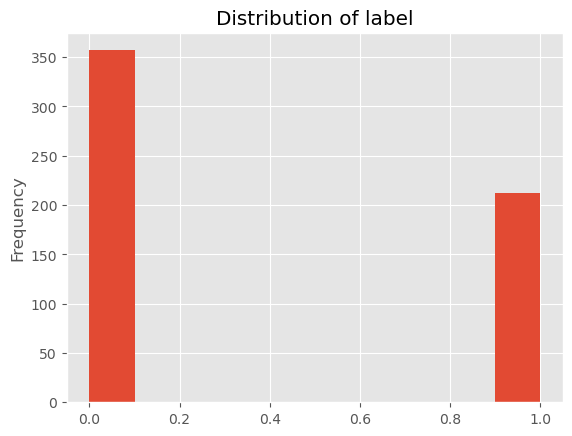

In [292]:
# check balance of diagnosis column
print(df['diagnosis'].value_counts())
# display histogram of diagnosis column
df['diagnosis'].astype('uint8').plot(kind='hist',
                                     title='Distribution of label')

## Feature selection

In [293]:
# Drop columns id and Unnamed: 32
df = df.drop(columns=['id', 'Unnamed: 32'])

In [294]:
# Analyse correlations of features with label
label_corr = pd.DataFrame(df.corr().diagnosis)

In [295]:
# Drop features barely correlating with label
important_features = label_corr.drop(label_corr[abs(label_corr.diagnosis) < 0.08].index)

<AxesSubplot: title={'center': 'Correlations with label'}>

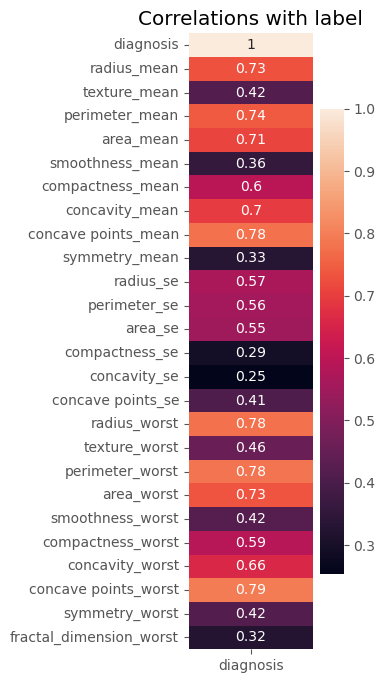

In [296]:
# Visualize the correlations
plt.subplots(figsize=(2,8))
plt.title('Correlations with label')
sns.heatmap(important_features, annot=True)

In [297]:
# Select only the important features
df = df[important_features.index]

<AxesSubplot: title={'center': 'Correlation matrix'}>

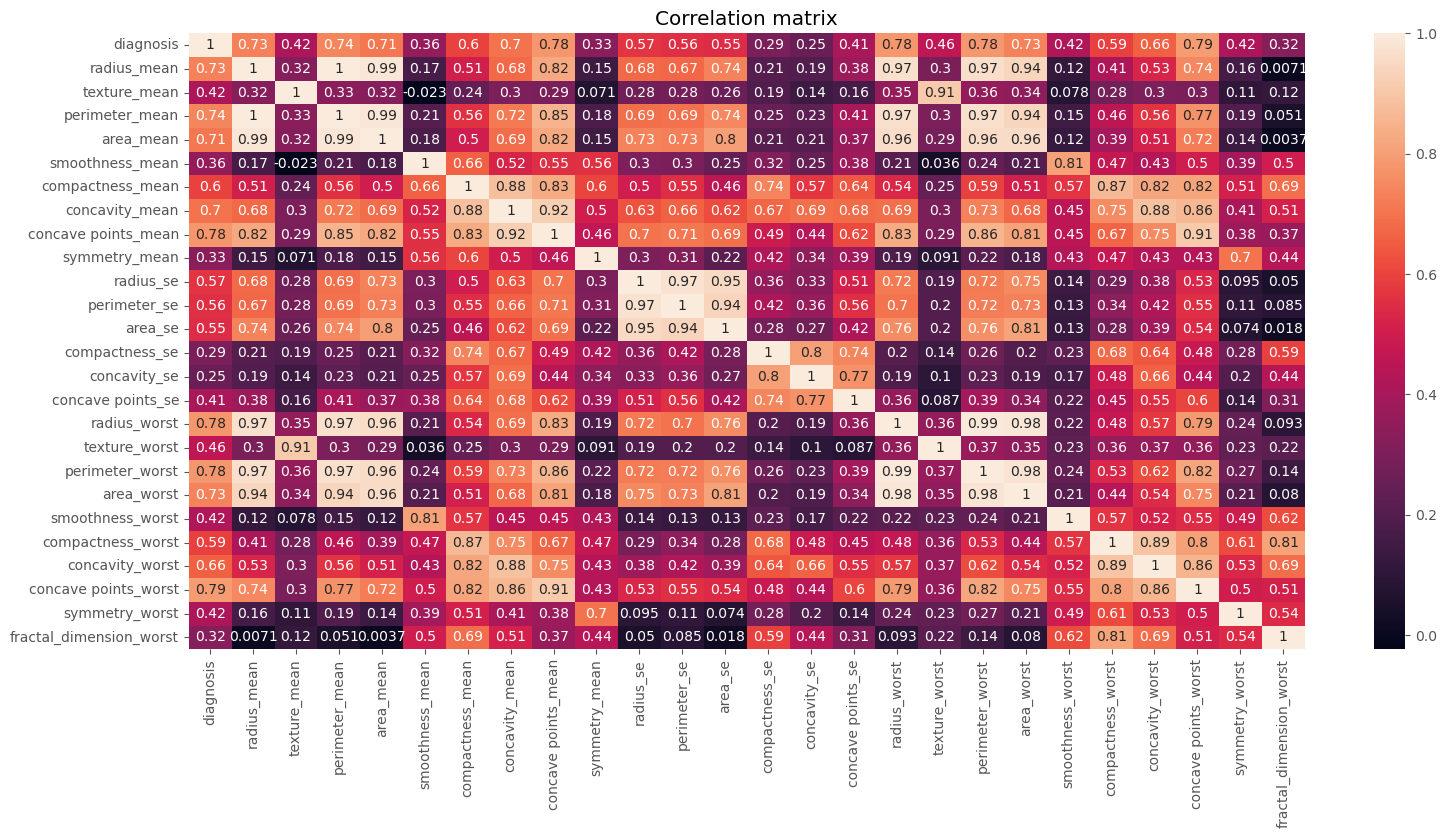

In [298]:
plt.subplots(figsize=(18,8))
plt.title('Correlation matrix')
sns.heatmap(df.corr(), annot=True, )

These features are all very correlated:
- radius_mean
- perimeter_mean
- area_mean
- radius_worst
- perimeter_worst
- area_worst

So we will preserve only 'radius_worst' since it has the highest correlation with label (along with 'perimeter_mean'), the others will be dropped

Same goes for:
- radius_se
- perimeter_se
- area_se

We preserve only 'radius_se' for same the reason as above.

In [299]:
# Drop correlated features
df = df.drop(columns= ['radius_mean', 'perimeter_mean', 'area_mean', 'perimeter_worst', 'area_worst', 'perimeter_se', 'area_se'])

## Features description and transformation
- No missing values
- All features continuous
- Target variable binary
- Target variable looks somewhat balanced, but maybe there is a room for under/oversampling, or smote

In [300]:
# Analyse distances between neighbors
nbrs = NearestNeighbors(n_neighbors=5).fit(df.drop(columns=['diagnosis']))
distances, _ = nbrs.kneighbors(df.drop(columns=['diagnosis']))

In [301]:
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

Text(0, 0.5, 'Epsilon')

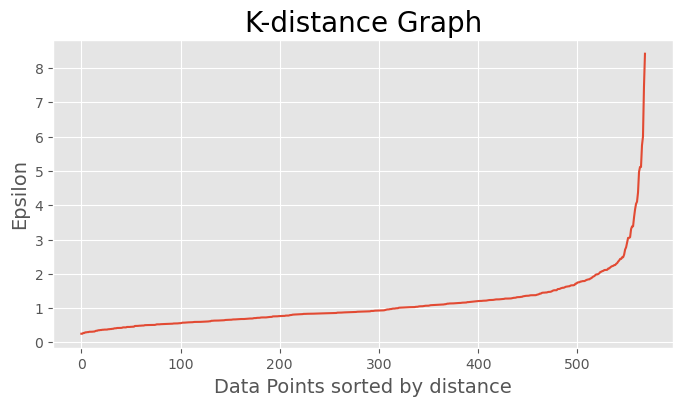

In [302]:
plt.subplots(figsize=(8,4))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)

Epsilon is at the point of maximum curvature which I think is around 6. The other parametrs including min_samples will remain default.

In [303]:
# Check for outliers
dbscan = DBSCAN(eps=6)
dbscan.fit(df.drop(columns=['diagnosis']))

DBSCAN(eps=6)

In [304]:
# Check the result
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0]), array([  5, 564]))

There is **5** outliers

In [305]:
# Drop outliers
df = df[(dbscan.labels_ == 0).T]
df.shape

(564, 19)

In [306]:
# check variance of each column
df.var()

diagnosis                   0.232729
texture_mean               17.022584
smoothness_mean             0.000199
compactness_mean            0.002802
concavity_mean              0.006293
concave points_mean         0.001489
symmetry_mean               0.000754
radius_se                   0.065408
compactness_se              0.000323
concavity_se                0.000917
concave points_se           0.000038
radius_worst               22.525792
texture_worst              34.823945
smoothness_worst            0.000520
compactness_worst           0.024725
concavity_worst             0.043705
concave points_worst        0.004318
symmetry_worst              0.003826
fractal_dimension_worst     0.000325
dtype: float64

Some columns have high variance, there is a room for scaling.

In [307]:
# apply standard scaler normalization to all columns except diagnosis
df_norm_standard = df.copy()
df_norm_standard.drop(['diagnosis'], axis=1, inplace=True)
df_norm_standard = df_norm_standard.apply(lambda x: (x - x.mean()) / x.std())
# add diagnosis column to normalized dataframe
df_norm_standard['diagnosis'] = df['diagnosis']

In [308]:
# check variance of each column after normalization
df_norm_standard.var()

texture_mean               1.000000
smoothness_mean            1.000000
compactness_mean           1.000000
concavity_mean             1.000000
concave points_mean        1.000000
symmetry_mean              1.000000
radius_se                  1.000000
compactness_se             1.000000
concavity_se               1.000000
concave points_se          1.000000
radius_worst               1.000000
texture_worst              1.000000
smoothness_worst           1.000000
compactness_worst          1.000000
concavity_worst            1.000000
concave points_worst       1.000000
symmetry_worst             1.000000
fractal_dimension_worst    1.000000
diagnosis                  0.232729
dtype: float64

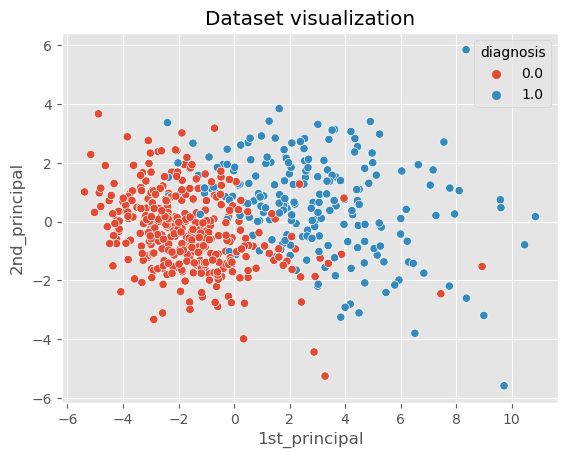

In [309]:
# visualize using PCA based on diagnosis column

# prepare PCA, set number of components to 2 for 2D visualization
pca = PCA(n_components=2)
# fit PCA to normalized dataframe
pca.fit(df_norm_standard.drop(['diagnosis'], axis=1))

# transform normalized dataframe
pca_data = pca.transform(df_norm_standard.drop(['diagnosis'], axis=1))
# add diagnosis column to transformed dataframe
pca_data = np.vstack((pca_data.T, df_norm_standard['diagnosis'].astype('uint8'))).T

# create dataframe from transformed data
pca_df = pd.DataFrame(data=pca_data, columns=('1st_principal', '2nd_principal', 'diagnosis'))

# visualize transformed data
ax = sns.scatterplot(x='1st_principal',
                     y='2nd_principal',
                     hue='diagnosis',
                     data=pca_df)
ax.set_title('Dataset visualization')
plt.show()

### pca description
Data looks normally distributed without any extreme values and can be separated even with a line in 2d space, it is expected, that even simple models like logistical regression or KNN will be able to classify data with high accuracy.

#### axis
- x it is hard to interpret axes according to original features, but this new feature is highly correlated to the target. It looks, that benign dots typically appear on the left side and malignant dots in the opposite direction.
- y axis doesn't separate data so clearly as x axes, but in combination with x can help with distinguishing bounding area points. Higher the Y is, more right data can be to still be benign.